In [50]:
import pandas as pd
from graph_tool.all import *
import numpy as np
import matplotlib
import csv
from datetime import datetime
import fastparquet
from tqdm import tqdm
import pickle

In [51]:
from PIL import Image
import os
class PlaceCanvas:
    def __init__(self, width, height):
        self.canvas = Image.new('RGB', (width, height), color = 'white')


    def update_pixel(self, x,y,color, mode='hex'):
        """
        Sets the specific x,y coordinate in the canvas to the given hex color.

        example:
        update_pixel(10,10,"#B4FBB8")
        """
        if mode=='hex':
            h = color.lstrip('#')
            rgb_value = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
            self.canvas.putpixel((x,y), rgb_value)
        if mode == 'rgbint':
            self.canvas.putpixel((x,y), color)

    def save_canvas(self, path = "images/"):
        if(os.path.exists(f'{path}images.png')):
            i = 0 
            while(os.path.exists(f'{path}images {i}.png')):
                i += 1
            self.canvas.save(f'{path}images {i}.png')
        else:
            self.canvas.save(f'{path}images.png')

    def get_image(self):
        return self.canvas

In [52]:
df_small = pd.read_parquet('2022_place_deephaven.parquet', engine='fastparquet')
df_small['timestamp'] = pd.to_datetime(df_small['timestamp'])

In [53]:
x1 = 0
x2 = 200
y1 = 0
y2 = 200

In [54]:
%%time
df_small = df_small[
    (df_small['timestamp'] > datetime.strptime('2022-04-01 12:30:00',"%Y-%m-%d %H:%M:%S")) & 
    (df_small['timestamp'] < datetime.strptime('2022-04-03 23:59:00',"%Y-%m-%d %H:%M:%S")) &
    (df_small['x1'] < x2) &
    (df_small['y1'] < y2)
]

CPU times: user 10.8 s, sys: 666 ms, total: 11.5 s
Wall time: 11.5 s


In [55]:
df_small.head(5)

,timestamp,user_id,rgb,x1,y1,x2,y2
0,2022-04-01 12:44:10.315,4068945,8318294,42,42,-32768,-32768
2,2022-04-01 12:44:26.626,4068947,3576042,44,42,-32768,-32768
3,2022-04-01 12:44:31.703,4068948,13948889,2,2,-32768,-32768
4,2022-04-01 12:44:44.409,4068949,3576042,23,23,-32768,-32768
6,2022-04-01 12:45:17.836,4068951,5368308,110,37,-32768,-32768


In [56]:
colors = ["#FFFFFF",
"#E4E4E4",
"#888888",
"#222222",
"#FFA7D1",
"#E50000",
"#E59500",
"#A06A42",
"#E5D900",
"#94E044",
"#02BE01",
"#00D3DD",
"#0083C7",
"#0000EA",
"#CF6EE4",
"#820080"]

In [57]:
dict_vertex = {}
dict_pixel = {}
dict_edges = {}

x1 = 0
x2 = 200
y1 = 0
y2 = 200

grid_size = 200
g = Graph(directed = False)

# internal properties
v_type = g.new_vertex_property("int") # user id for last action for each pixel
v_filter = g.new_vertex_property("bool") # the color of this action
v_action_count = g.new_vertex_property("int") # action count for the user
v_id = g.new_vertex_property("string") # type of vertex
v_last_action_user = g.new_vertex_property("string") # id for vertex
v_last_vertex_date = g.new_vertex_property("string")

count = 0
# user_id = 0
canvas_2 = PlaceCanvas(grid_size,grid_size)
curr_hour = 0
curr_day = 0

for row in tqdm(df_small.values):
        
  
    date = row[0]
#     try:
#         date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
#     except:
#         date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f")
    user = row[1]
    color = row[2]
    coord0 = int(row[3])
    coord1 = int(row[4])
    coords = f"{coord0}|{coord1}"
    color_str = str(color)
    
    
    if True:
    
        if date.hour > curr_hour or date.day > curr_day: #date.day == 4 and date.hour < 24:
            canvas_2.save_canvas(path="")
#             canvas_2 = PlaceCanvas(grid_slize,grid_size)
    
        
        if x1 < coord0 < x2 and y1 < coord1 < y2:

#                 print(row)
            if count % 100000 == 0:
                print(date)
            canvas_2.update_pixel(coord0-x1, coord1-y1, color, mode='rgbint')




            if user not in dict_vertex:
                # if no user in graph add vertex to dictionary, add vertex to graph
                dict_vertex[user] = g.add_vertex() # this also adds the vertex to graph g
                v_id[dict_vertex[user]] = user # internal property of user id for graph vertices
#                 user_id += 1
                v_type[dict_vertex[user]] = 0 # internal property of vertex type
                v_action_count[dict_vertex[user]] = 1 # internal property of user's actions

            else:
                v_action_count[dict_vertex[user]] += 1 # add action count for the user
                if v_action_count[dict_vertex[user]] >2: # action count boolean property for filtering out users that did only few actions
                    v_filter[dict_vertex[user]] = True

            if f"{color}|{coords}" not in dict_vertex:
                # if no color/pixel in graph add vertex to dictionary, add vertex to graph
                dict_vertex[f"{color}|{coords}"] = g.add_vertex()  
                v_id[dict_vertex[f"{color}|{coords}"]] = f"{color}|{coords}"
                v_type[dict_vertex[f"{color}|{coords}"]] = 1
                v_filter[dict_vertex[f"{color}|{coords}"]] = True # always set to true to not filter out pixels



            if f"{user}|{color}|{coords}" not in dict_edges:
                # if a user performed exactly the same action twice we want to have it in the dictionary
                e = g.add_edge(dict_vertex[user], dict_vertex[f"{color}|{coords}"]) # add edge 
                dict_edges[f"{user}|{color}|{coords}"] = 1 # record that we added this edge already

            v_last_vertex_date[dict_vertex[user]] = date
            v_last_vertex_date[dict_vertex[f"{color}|{coords}"]] = date
            v_last_action_user[dict_vertex[f"{color}|{coords}"]] = user # overwrite the last action for a color/pixel by user id
            dict_pixel[coords] = user

            count += 1


    else: 
        break
      
    curr_hour = date.hour
    curr_day = date.day
        
# canvas_2.save_canvas(path="")

  0%|                                                                           | 992/2433413 [00:00<04:05, 9915.47it/s]

2022-04-01 12:44:10.315000


  4%|███▏                                                                   | 108226/2433413 [00:11<03:49, 10149.73it/s]

2022-04-01 16:10:44.499000


  9%|██████▍                                                                 | 215533/2433413 [00:22<03:43, 9917.68it/s]

2022-04-01 19:04:32.704000


 13%|█████████▍                                                              | 320306/2433413 [00:33<03:32, 9947.66it/s]

2022-04-01 21:04:59.658000


 17%|████████████▌                                                           | 423502/2433413 [00:43<03:32, 9468.82it/s]

2022-04-01 22:30:39.916000


 22%|███████████████▌                                                        | 526451/2433413 [00:54<03:14, 9820.60it/s]

2022-04-01 23:52:06.911000


 26%|██████████████████▌                                                     | 628360/2433413 [01:04<03:02, 9903.65it/s]

2022-04-02 01:33:22.148000


 30%|█████████████████████▎                                                 | 731481/2433413 [01:14<02:47, 10172.76it/s]

2022-04-02 03:24:10.829000


 34%|████████████████████████▋                                               | 834116/2433413 [01:25<02:44, 9709.85it/s]

2022-04-02 05:40:38.485000


 39%|███████████████████████████▋                                            | 937759/2433413 [01:36<02:41, 9273.64it/s]

2022-04-02 08:20:20.872000


 43%|█████████████████████████████▉                                        | 1039727/2433413 [01:46<02:18, 10071.76it/s]

2022-04-02 11:01:43.859000


 47%|████████████████████████████████▉                                     | 1142846/2433413 [01:57<02:06, 10168.36it/s]

2022-04-02 13:28:35.849000


 51%|███████████████████████████████████▊                                  | 1246692/2433413 [02:07<01:55, 10235.87it/s]

2022-04-02 15:33:21.967000


 55%|██████████████████████████████████████▊                               | 1348894/2433413 [02:17<01:45, 10312.86it/s]

2022-04-02 17:36:01.094000


 60%|█████████████████████████████████████████▊                            | 1452380/2433413 [02:27<01:36, 10157.06it/s]

2022-04-02 19:57:57.561000


 64%|████████████████████████████████████████████▊                         | 1557213/2433413 [02:38<01:26, 10143.36it/s]

2022-04-02 22:18:38.302000


 68%|███████████████████████████████████████████████▊                      | 1661845/2433413 [02:48<01:14, 10352.35it/s]

2022-04-03 01:35:59.799000


 73%|██████████████████████████████████████████████████▊                   | 1766888/2433413 [02:58<01:04, 10352.12it/s]

2022-04-03 04:38:42.030000


 77%|██████████████████████████████████████████████████████▌                | 1871378/2433413 [03:09<00:56, 9949.58it/s]

2022-04-03 08:33:59.432000


 81%|████████████████████████████████████████████████████████▊             | 1974881/2433413 [03:19<00:45, 10163.80it/s]

2022-04-03 12:22:30.821000


 85%|███████████████████████████████████████████████████████████▊          | 2078257/2433413 [03:29<00:34, 10242.38it/s]

2022-04-03 14:42:55.077000


 90%|██████████████████████████████████████████████████████████████▊       | 2183266/2433413 [03:40<00:24, 10126.89it/s]

2022-04-03 16:59:04.382000


 94%|█████████████████████████████████████████████████████████████████▊    | 2288289/2433413 [03:50<00:13, 10466.09it/s]

2022-04-03 19:12:34.297000


 98%|████████████████████████████████████████████████████████████████████▉ | 2394835/2433413 [04:00<00:03, 10707.85it/s]

2022-04-03 22:32:50.239000


100%|███████████████████████████████████████████████████████████████████████| 2433413/2433413 [04:04<00:00, 9960.14it/s]


In [58]:
with open('dict_pixel.pkl', 'wb') as f:
    pickle.dump(dict_pixel, f)

In [59]:
g.vp.v_type = v_type
g.vp.v_id = v_id
g.vp.v_last_action_user = v_last_action_user
g.vp.v_last_vertex_date = v_last_vertex_date

In [60]:
%%time
g.save('graph_full.gt')

CPU times: user 263 ms, sys: 86 ms, total: 349 ms
Wall time: 348 ms


In [61]:
g

<Graph object, undirected, with 1051991 vertices and 2178789 edges, 4 internal vertex properties, at 0x7f12cb0d2450>

In [62]:
old_sub = GraphView(g, v_filter)

In [63]:
sub_g = Graph(old_sub, prune=True)

In [64]:
# graph_draw(sub_g, vertex_text=sub_g.vertex_index, output="whole_graph.pdf", vertex_fill_color=sub_g.vp.v_type)

In [65]:
sub_g

<Graph object, undirected, with 465333 vertices and 1476008 edges, 4 internal vertex properties, at 0x7f124a4b2e10>

In [66]:
%%time
sub_g.save('sub_g.gt')

CPU times: user 85.5 ms, sys: 43 ms, total: 129 ms
Wall time: 127 ms



# Fillter out unconnected nodes

In [67]:
in_degs = sub_g.get_in_degrees(sub_g.get_vertices())
out_degs = sub_g.get_out_degrees(sub_g.get_vertices())

In [68]:
v_filter_deg = sub_g.new_vertex_property("bool")

In [69]:
for i in range(len(in_degs)):
    if (in_degs[i] != 0) or (out_degs[i] != 0):
        v_filter_deg[i] = True

In [70]:
v_con_sub_g = GraphView(sub_g, v_filter_deg)

In [71]:
v_con_sub_g

<GraphView object, undirected, with 397668 vertices and 1476008 edges, 4 internal vertex properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f1248458590, at 0x7f124a461e10>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f1248458590, at 0x7f126a6611d0>, False), at 0x7f1248458590>

In [72]:
%%time
v_con_sub_g.save('graph_filtered.gt')

CPU times: user 129 ms, sys: 52 ms, total: 181 ms
Wall time: 179 ms


In [73]:
# graph_draw(v_con_sub_g, vertex_text=v_con_sub_g.vertex_index, output="filtered_graph.pdf", vertex_fill_color=v_con_sub_g.vp.v_type)

## Communities

### Loading saved graph

In [74]:
# v_con_sub_g = Graph(directed = False)

In [75]:
# v_con_sub_g.load('graph_filtered.gt')

In [76]:
# v_con_sub_g.list_properties()

### model

In [77]:
%%time
state = minimize_blockmodel_dl(v_con_sub_g)

CPU times: user 35min 56s, sys: 28 s, total: 36min 24s
Wall time: 36min 27s


In [34]:
# state.draw(output="football-sbm-fit.pdf",vertex_font_size=0.4, vertex_text=v_con_sub_g.vp.v_id)

In [78]:
b = state.get_blocks()

In [79]:
df = pd.DataFrame(np.column_stack([list(sub_g.vp.v_id), list(b.a),list(sub_g.vp.v_type)]), columns=['id','community','type'])

In [80]:
df_last = pd.DataFrame(np.column_stack([list(sub_g.vp.v_id), list(sub_g.vp.v_last_action_user),list(sub_g.vp.v_type)]), columns=['id','last', 'type'])

In [81]:
df_last['pixel'] = df_last[df_last.type=="1"].id.str.split('|')

In [82]:
last_pixel = pd.DataFrame(np.column_stack([list(dict_pixel.keys()), list(dict_pixel.values())]), columns = ['coords','user'])

In [83]:
user_community = df[(df.community != 0) & (df.type == '0')]

In [84]:
df_vis = pd.merge(last_pixel, user_community, how = 'left', left_on='user', right_on = 'id')

In [85]:
df_vis = df_vis.dropna()[['coords','community']]

In [86]:
df_vis.to_csv('df_vis.csv')

# Community vis over time

In [87]:
df_com = df[(df.community != 0) & (df.type == '0')]

In [88]:
user_community.id = user_community.id.astype(int)

/tmp/ipykernel_1341/3123547573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_community.id = user_community.id.astype(int)


In [89]:
df_small = df_small.merge(user_community, how='inner', left_on='user_id', right_on='id')

In [108]:
sum(df_small.community.value_counts() > 100)

126

In [90]:
colors = dict(zip(df_small['community'].unique(),
                  (f'{c}' for c in matplotlib.colors.cnames.values())))

In [102]:
len(matplotlib.colors.cnames.values())

148

In [98]:
len(df_small['community'].unique())

172

In [100]:
len(colors)

148

In [91]:
df_small['color_comm'] = df_small['community'].map(colors)

In [92]:
for d in range(1,4):
    for h in range(0,24):
        if d > 1 or h >= 12:
            df_chunk = df_small[
                (df_small['timestamp'] > datetime.strptime('2022-04-01 12:30:00',"%Y-%m-%d %H:%M:%S")) & 
                (df_small['timestamp'] < datetime.strptime(f'2022-04-0{d} {h}:59:00',"%Y-%m-%d %H:%M:%S")) &
                (x1 < df_small.x1) &
                (df_small.x1 < x2) &
                (y1 < df_small.y1) &
                (df_small.y1 < y2) &
                (df_small['user_id'].isin(user_community.id.astype(int)))
            ]
            df_chunk_last = df_chunk.drop_duplicates(subset=["x1","y1"], keep="last")
            canvas_2 = PlaceCanvas(grid_size,grid_size)
            for row in tqdm(df_chunk_last.values):
                canvas_2.update_pixel(row[3]-x1, row[4]-y1, row[10], mode='hex')

            canvas_2.save_canvas(path="")

0it [00:00, ?it/s]
 97%|██████████████████████████████████████████████████████████████████████▌  | 27944/28934 [00:00<00:00, 337969.03it/s]


AttributeError: 'float' object has no attribute 'lstrip'

In [93]:
row

array([Timestamp('2022-04-01 17:44:27.313000'), 3880969, 10250534, 117,
       114, -32768, -32768, 3880969, '236593', '0', nan], dtype=object)

## Community vis

In [48]:
canvas = PlaceCanvas(100,100)

In [42]:
colors = dict(zip(df_small['community'].unique(),
                  (f'{c}' for c in matplotlib.colors.cnames.values())))

In [43]:
colors

{'74160': '#F0F8FF',
 '42246': '#FAEBD7',
 '2973': '#00FFFF',
 '90703': '#7FFFD4',
 '124535': '#F0FFFF',
 '110286': '#F5F5DC',
 '20374': '#FFE4C4',
 '88482': '#000000',
 '119789': '#FFEBCD',
 '4139': '#0000FF',
 '34217': '#8A2BE2',
 '95289': '#A52A2A',
 '54488': '#DEB887',
 '32494': '#5F9EA0',
 '95590': '#7FFF00',
 '128592': '#D2691E',
 '58247': '#FF7F50',
 '41746': '#6495ED',
 '75963': '#FFF8DC',
 '22338': '#DC143C',
 '54818': '#00FFFF',
 '132999': '#00008B',
 '51868': '#008B8B',
 '122604': '#B8860B',
 '78421': '#A9A9A9',
 '53485': '#006400',
 '124200': '#A9A9A9',
 '114752': '#BDB76B',
 '76935': '#8B008B',
 '95366': '#556B2F',
 '47888': '#FF8C00',
 '101653': '#9932CC',
 '53342': '#8B0000',
 '82132': '#E9967A',
 '77100': '#8FBC8F',
 '61718': '#483D8B',
 '46161': '#2F4F4F',
 '67417': '#2F4F4F',
 '102465': '#00CED1',
 '52680': '#9400D3',
 '30154': '#FF1493',
 '79240': '#00BFFF',
 '43069': '#696969',
 '101104': '#696969',
 '90791': '#1E90FF',
 '114637': '#B22222',
 '49804': '#FFFAF0',
 '2

In [51]:
df_vis = df_vis.replace({"community": colors})

In [52]:
df_vis

,coords,community
0,42|42,#F0F8FF
1,44|42,#F0F8FF
2,5|55,#FAEBD7
4,8|104,#00FFFF
5,61|95,#7FFFD4
...,...,...
9793,98|109,#FFEBCD
9795,12|126,#00FFFF
9797,51|119,#FF7F50
9798,22|130,#00FFFF


In [53]:
for index, row in df_vis.iterrows():
    x,y = row.coords.split("|")
    canvas.update_pixel(int(x)-x1,int(y)-y1,row.community)
    

TypeError: color must be int or tuple

In [ ]:
canvas.save_canvas(path="")

# Full graph communities

In [64]:
g.save('graph_test.gt')

In [65]:
full_graph = load_graph('graph_test.gt')

In [5]:
full_graph = load_graph('my_graph.xml')

In [7]:
full_graph

<Graph object, directed, with 32351787 vertices and 139834505 edges, at 0x7f1e9b706ce0>

In [8]:
v1 = full_graph.vertex(8093)

In [66]:
full_graph.list_properties()

v_id                   (vertex)  (type: string)
v_last_action_user     (vertex)  (type: string)
v_type                 (vertex)  (type: int32_t)


In [67]:
full_graph.vp

{'v_type': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f1e5b9a11e0, at 0x7f1e5b7879d0>, 'v_id': <VertexPropertyMap object with value type 'string', for Graph 0x7f1e5b9a11e0, at 0x7f1e5b7875b0>, 'v_last_action_user': <VertexPropertyMap object with value type 'string', for Graph 0x7f1e5b9a11e0, at 0x7f1e5b786320>}

In [ ]:
in_degs = sub_g.get_in_degrees(sub_g.get_vertices())
out_degs = sub_g.get_out_degrees(sub_g.get_vertices())

In [ ]:
v_filter_deg = sub_g.new_vertex_property("bool")

# Tests

In [102]:
v_test = v_con_sub_g.vertex(4275)
v_con_sub_g.vp.v_id[v_test]

'8Zbajz0Scbc0fb2vYNo2BNUnW85I1/TBZPoFUTkODd4z/QRk9/AdvaDYd/F34ZTHkgtk7Nvb4a5hyMJXgfflHQ=='

In [104]:
for key in v_con_sub_g.vp.keys():
    print(key)

v_type
v_id


In [105]:
for edge in g.vertex(4275).all_edges():
    print(edge)

(4275, 4274)


In [115]:
v1 = old_sub.vertex(4275)

In [117]:
old_sub.vp.v_id[v1][:15]

'#00A368"1169|8"'

In [108]:
v1 = sub_g.vertex(4275)

In [118]:
sub_g.vp.v_id[v1][:15]

'8Zbajz0Scbc0fb2'

In [111]:
v1 = g.vertex(8093)

In [112]:
g.vp.v_id[v1]

'8Zbajz0Scbc0fb2vYNo2BNUnW85I1/TBZPoFUTkODd4z/QRk9/AdvaDYd/F34ZTHkgtk7Nvb4a5hyMJXgfflHQ=='

In [21]:
for edge in old_sub.vertex(4275).all_edges():
    print(edge)

In [11]:
sub_g

<Graph object, undirected, with 3994 vertices and 959 edges, 3 internal vertex properties, at 0x7f20a1c87520>

In [22]:
list(sub_g.vp.v_id)

['#D4D7D9"52|7"',
 '1',
 '#FFFFFF"24|96"',
 '#000000"15|2"',
 '#FFFFFF"64|22"',
 '#E4ABFF"0|6"',
 '#515252"54|78"',
 '#7EED56"0|0"',
 '#000000"85|29"',
 '#000000"81|94"',
 '#000000"3|0"',
 '#2450A4"68|98"',
 '11',
 '#00CC78"75|76"',
 '#FFFFFF"2|38"',
 '#000000"52|7"',
 '#FFFFFF"78|11"',
 '#DE107F"4|0"',
 '#000000"69|69"',
 '#000000"34|4"',
 '#FFFFFF"18|87"',
 '#BE0039"93|47"',
 '21',
 '#9C6926"2|65"',
 '#FFFFFF"36|99"',
 '23',
 '#000000"52|64"',
 '#000000"54|65"',
 '#FFFFFF"0|33"',
 '#51E9F4"0|4"',
 '#FFFFFF"5|57"',
 '28',
 '#000000"20|82"',
 '#000000"2|2"',
 '#FFFFFF"60|21"',
 '#E4ABFF"1|81"',
 '#FFFFFF"0|0"',
 '#515252"2|2"',
 '#000000"24|95"',
 '#000000"75|13"',
 '#FFFFFF"26|26"',
 '#000000"33|17"',
 '#FFFFFF"0|1"',
 '#000000"8|28"',
 '#FFFFFF"0|3"',
 '#000000"5|57"',
 '#000000"76|23"',
 '#7EED56"5|0"',
 '#2450A4"69|92"',
 '#000000"80|9"',
 '48',
 '#FFFFFF"21|95"',
 '50',
 '#FFFFFF"31|79"',
 '#000000"56|0"',
 '#811E9F"0|0"',
 '#FFFFFF"74|6"',
 '#FFA800"8|0"',
 '#000000"22|95"',
 '#0

In [15]:
for edge in g.vertex(200).all_edges():
    print(edge)

(200, 199)
(200, 2259)
(200, 3277)
(200, 3280)


In [16]:
for edge in sub_g.vertex(200).all_edges():
    print(edge)

(200, 199)


In [23]:
for edge in v_con_sub_g.vertex(4275).all_edges():
    print(edge)

(4275, 4276)
(4275, 5783)
(4275, 7356)
(4275, 8919)
(4275, 11625)
(4275, 13096)
(4275, 14497)
(4275, 16119)
(4275, 17713)


In [25]:
for edge in dict_vertex['8Zbajz0Scbc0fb2vYNo2BNUnW85I1/TBZPoFUTkODd4z/QRk9/AdvaDYd/F34ZTHkgtk7Nvb4a5hyMJXgfflHQ=='].all_edges():
    print(edge)

(8093, 8094)
(8093, 10976)
(8093, 14092)
(8093, 17252)
(8093, 22818)
(8093, 25944)
(8093, 28964)
(8093, 32542)
(8093, 36025)


In [256]:
dict_vertex

{'neOdfPFywDW+27oZPIQTTND8XrdpxNprL3djflcEse30DvB3cUeXmkk0433s1u6hTKS0sJlauy97nxfffnZD7A==': <Vertex object with index '0' at 0x1d59a07b0>,
 '#FFFFFF"1169|8"': <Vertex object with index '1' at 0x1d59a3370>,
 'Uj516Da76vRFlduIU/9XCjkqKkjkOadNy9l7Uou5kUQT8YLBb8+BUMHb9KhMQ07vOgMdueM4jXrAfOWspzmWFA==': <Vertex object with index '2' at 0x1d59a2340>,
 '#BE0039"9|1349"': <Vertex object with index '3' at 0x1d59a2110>,
 'lSzxKxeOO7wPnHVJZukNkE6KKpPxgfjdFYpTsgcrmsLQXj1M8VcIhxgxzNouuUU+1pgOWIZNwOI3rhZp7U3b0Q==': <Vertex object with index '4' at 0x1d59a2490>,
 '#D4D7D9"52|7"': <Vertex object with index '5' at 0x1d59a1fc0>,
 'NEPi1MYeEzOQ2ectLpueAhcHPH+2qKYLlQWgPBEGrJF1UnEZV8QVKPsZT1SviB4YfQSwUyqfgz0Lp5qnnyH4/A==': <Vertex object with index '6' at 0x1d59a2180>,
 '#FFA800"385|2"': <Vertex object with index '7' at 0x1d59a12a0>,
 '8XKUQZ6w0aHrrZM7Sevh7Fq9QFPl8wLP/XiJxvyzGVed2K9p21zNFd+XvifN6FccpGeHirL1Dsgo0hT1sJ5ZvA==': <Vertex object with index '8' at 0x1d59a1000>,
 '#000000"1|1971"': <Vertex object 

# Image segmentation

In [56]:
import matplotlib.pyplot as plt

In [64]:
image = plt.imread('images 30.png')

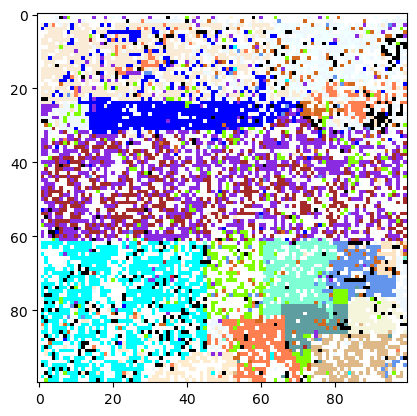

In [65]:
plt.imshow(image)

In [80]:
from PIL import Image

In [169]:
im = Image.open('images 30.png')

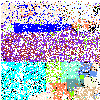

In [170]:
im.show()

In [171]:
pix = im.load()

In [179]:
pp = pix[19,5]

In [180]:
pp

(0, 0, 255)

In [87]:
n = pp[0]^2 + pp[1] + pp[2]

In [173]:
def getRGBfromI(RGBint):
    blue =  RGBint & 255
    green = (RGBint >> 8) & 255
    red =   (RGBint >> 16) & 255
    return red, green, blue

def getIfromRGB(rgb):
    red = rgb[0]
    green = rgb[1]
    blue = rgb[2]
    RGBint = (red<<16) + (green<<8) + blue
    return RGBint

def rgb_int2tuple(rgbint):
    return (rgbint // 256 // 256 % 256, rgbint // 256 % 256, rgbint % 256)

In [181]:
getIfromRGB(pp)

255

In [89]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb
rgb_to_hex((255, 255, 195))

'ffffc3'

In [88]:
n

243

In [215]:
stepSize = 1
windowSize = [5,5]

In [72]:
from scipy import stats

In [191]:
y = 50
x = 50

In [105]:
test_vec = np.vectorize(getIfromRGB)

In [135]:
vec_to_rgb = np.vectorize(rgb_int2tuple)

In [106]:
arr = test_vec(b)

In [108]:
arr.shape

(100, 100)

In [193]:
window = arr[y:y + windowSize[1], x:x + windowSize[0]]

In [100]:
import numpy.lib.recfunctions as nlr

b = nlr.unstructured_to_structured(a).astype('O')

In [102]:
b[0,0]

(255, 255, 255)

In [99]:
a = np.array(im)

In [205]:
(-res[:, 1]).argsort()

array([7, 2, 3, 1, 0, 4, 5, 6])

In [207]:
unique, counts = np.unique(window, return_counts=True)
res = np.asarray((unique, counts)).T
res = res[(-res[:, 1]).argsort()]

In [213]:
res.shape[0]

1

In [216]:
canvas = PlaceCanvas(100,100)
new_im = np.zeros((100,100))
for y in range(0, a.shape[0], stepSize):
    for x in range(0, a.shape[1], stepSize):
    # yield the current window
#         print(x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
        window = arr[y:y + windowSize[1], x:x + windowSize[0]]
        m = stats.mode(window, axis = None)
        print(np.unique(window, return_counts=True))
        unique, counts = np.unique(window, return_counts=True)
        res = np.asarray((unique, counts)).T
        res = res[(-res[:, 1]).argsort()]
#         print(m[0][0])
#         new_im[x,y] = rgb_int2tuple(m[0][0])
        if res[0,0] == 16777215 and res.shape[0] > 1:
            col_fill = res[1,0]
        else:
            col_fill = res[0,0]
        canvas.update_pixel(int(x),int(y),rgb_int2tuple(col_fill))
#         plt.imshow(image[y:y + windowSize[1], x:x + windowSize[0]])

canvas.save_canvas(path="")

/tmp/ipykernel_921/3464215756.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  m = stats.mode(window, axis = None)


(array([     255, 16444375, 16744272, 16777215]), array([ 2,  5,  1, 17]))
(array([     255, 15792383, 16444375, 16744272, 16777215]), array([ 2,  2,  6,  1, 14]))
(array([       0,      255, 15792383, 16444375, 16744272, 16777215]), array([ 1,  1,  3,  6,  1, 13]))
(array([       0,  9055202, 15792383, 16444375, 16744272, 16777215]), array([ 1,  1,  3,  7,  1, 12]))
(array([       0,  8388352,  9055202, 15792383, 16444375, 16744272,
       16777215]), array([ 1,  1,  1,  4,  5,  1, 12]))
(array([       0,      255,  8388352,  9055202, 15792383, 16444375,
       16777215]), array([ 1,  2,  1,  1,  4,  4, 12]))
(array([       0,      255,  8388352,  9055202, 15792383, 16444375,
       16777215]), array([ 1,  2,  1,  1,  2,  5, 13]))
(array([     255,  8388352,  9055202, 15792383, 16444375, 16777215]), array([ 2,  1,  2,  1,  5, 14]))
(array([     255,  8388352,  9055202, 15792383, 16444375, 16777215]), array([ 2,  1,  1,  2,  4, 15]))
(array([     255,  9055202, 15792383, 16444375, 1677

(array([       0, 13789470, 15792383, 15794175, 16772045, 16777215]), array([ 1,  1,  6, 13,  1,  3]))
(array([       0,  9055202, 13789470, 15792383, 15794175, 16772045,
       16777215]), array([ 1,  1,  1,  5, 13,  1,  3]))
(array([ 9055202, 13789470, 15792383, 15794175, 16772045, 16777215]), array([ 1,  2,  6, 12,  1,  3]))
(array([ 9055202, 13789470, 15792383, 15794175, 16772045, 16777215]), array([ 1,  1,  6, 10,  1,  6]))
(array([ 9055202, 13789470, 15792383, 15794175, 16772045, 16777215]), array([1, 2, 5, 8, 1, 8]))
(array([ 9055202, 13789470, 15792383, 15794175, 16777215]), array([1, 2, 9, 6, 7]))
(array([13789470, 15792383, 15794175, 16777215]), array([ 2,  9,  4, 10]))
(array([13789470, 15792383, 15794175, 16777215]), array([ 1,  7,  4, 13]))
(array([       0, 13789470, 15792383, 15794175, 16444375, 16777215]), array([ 2,  2,  5,  5,  1, 10]))
(array([       0, 13789470, 15792383, 15794175, 16444375, 16777215]), array([4, 1, 6, 4, 1, 9]))
(array([       0, 13789470, 15792383

(array([     255,  8388352,  9055202, 15792383, 16444375, 16777215]), array([ 2,  1,  1,  3, 12,  6]))
(array([     255,  8388352,  9055202, 15792383, 16444375, 16777215]), array([ 2,  1,  2,  2, 13,  5]))
(array([       0,      255,  8388352,  9055202, 16444375, 16777215]), array([ 1,  3,  1,  1, 15,  4]))
(array([       0,      255,  8388352,  9055202, 16444375, 16744272,
       16777215]), array([ 1,  4,  1,  1, 13,  1,  4]))
(array([       0,      255,  8388352,  9055202, 16444375, 16744272,
       16777215]), array([ 1,  2,  1,  1, 15,  1,  4]))
(array([       0,      255,  8388352,  9055202, 16444375, 16744272,
       16777215]), array([ 1,  2,  2,  1, 14,  1,  4]))
(array([       0,      255,  8388352, 16444375, 16744272, 16777215]), array([ 1,  4,  2, 12,  2,  4]))
(array([     255,  8388352, 16444375, 16744272, 16777215]), array([ 3,  2, 11,  2,  7]))
(array([     255,  8388352, 15794175, 16444375, 16744272, 16777215]), array([ 3,  1,  1, 13,  1,  6]))
(array([     255,  83883

(array([     255,  9055202, 15792383, 16777215]), array([22,  1,  1,  1]))
(array([     255,  9055202, 15792383, 16777215]), array([21,  1,  2,  1]))
(array([     255, 15792383, 16777215]), array([21,  2,  2]))
(array([     255, 15792383, 16777215]), array([20,  2,  3]))
(array([     255, 15792383, 16777215]), array([19,  2,  4]))
(array([     255, 15792383, 16777215]), array([21,  1,  3]))
(array([     255, 16777215]), array([22,  3]))
(array([     255, 16777215]), array([22,  3]))
(array([     255, 16777215]), array([23,  2]))
(array([       0,      255, 16777215]), array([ 1, 23,  1]))
(array([       0,      255, 16777215]), array([ 1, 22,  2]))
(array([       0,      255, 16777215]), array([ 1, 22,  2]))
(array([       0,      255, 13789470, 16777215]), array([ 1, 22,  1,  1]))
(array([       0,      255, 13789470, 16777215]), array([ 1, 22,  1,  1]))
(array([     255, 13789470, 16777215]), array([23,  1,  1]))
(array([     255, 13789470]), array([24,  1]))
(array([     255,  90552

(array([     255,  8388352,  9055202, 10824234, 15792383, 16777215]), array([ 1,  1, 10,  7,  1,  5]))
(array([     255,  8388352,  9055202, 10824234, 15792383, 15794175,
       16775388, 16777215]), array([ 1,  1, 10,  6,  1,  1,  1,  4]))
(array([ 8388352,  9055202, 10824234, 15794175, 16775388, 16777215]), array([2, 9, 6, 1, 1, 6]))
(array([ 8388352,  9055202, 10824234, 15794175, 16775388, 16777215]), array([2, 9, 7, 1, 1, 5]))
(array([ 8388352,  9055202, 10824234, 15794175, 16775388, 16777215]), array([1, 7, 9, 1, 1, 6]))
(array([ 8388352,  9055202, 10824234, 15794175, 16775388, 16777215]), array([ 1,  7, 10,  1,  1,  5]))
(array([ 8388352,  9055202, 10824234, 16777215]), array([1, 8, 9, 7]))
(array([ 9055202, 10824234, 16777215]), array([ 8, 10,  7]))
(array([ 9055202, 10824234, 16777215]), array([ 9, 10,  6]))
(array([ 9055202, 10824234, 16777215]), array([10,  8,  7]))
(array([ 9055202, 10824234, 16777215]), array([11,  6,  8]))
(array([ 9055202, 10824234, 16777215]), array([12,

(array([ 9055202, 10824234, 13789470, 16772045, 16777215]), array([ 9,  3,  1,  2, 10]))
(array([ 9055202, 10824234, 13789470, 16772045, 16777215]), array([11,  2,  1,  2,  9]))
(array([ 8388352,  9055202, 10824234, 13789470, 16772045, 16777215]), array([ 1, 10,  3,  1,  2,  8]))
(array([ 8388352,  9055202, 10824234, 16772045, 16777215]), array([ 1, 10,  2,  2, 10]))
(array([ 8388352,  9055202, 10824234, 16777215]), array([ 1, 11,  3, 10]))
(array([ 8388352,  9055202, 10824234, 16777215]), array([ 1, 10,  3, 11]))
(array([ 8388352,  9055202, 10824234, 16777215]), array([ 2,  9,  3, 11]))
(array([ 8388352,  9055202, 10824234, 16777215]), array([ 1,  7,  2, 10]))
(array([ 8388352,  9055202, 10824234, 16777215]), array([1, 5, 2, 7]))
(array([ 8388352,  9055202, 10824234, 16777215]), array([1, 1, 1, 7]))
(array([ 8388352,  9055202, 10824234, 16777215]), array([1, 1, 1, 2]))
(array([ 9055202, 10824234, 16777215]), array([10,  6,  9]))
(array([ 9055202, 10824234, 16777215]), array([11,  8,  

(array([ 9055202, 10824234, 15794175, 16770244, 16772045, 16777215]), array([7, 5, 1, 1, 2, 9]))
(array([ 9055202, 10824234, 15794175, 16770244, 16777215]), array([ 6,  5,  1,  1, 12]))
(array([ 9055202, 10824234, 15794175, 16770244, 16777215]), array([ 5,  5,  1,  1, 13]))
(array([ 9055202, 10824234, 15794175, 16770244, 16777215]), array([ 5,  6,  1,  1, 12]))
(array([ 9055202, 10824234, 16770244, 16777215]), array([ 5,  8,  1, 11]))
(array([ 9055202, 10824234, 16777215]), array([ 4,  9, 12]))
(array([ 9055202, 10824234, 16777215]), array([ 7,  7, 11]))
(array([     255,  6591981,  9055202, 10824234, 16777215]), array([ 1,  1,  7,  5, 11]))
(array([     255,  6591981,  9055202, 10824234, 15792383, 16777215]), array([ 1,  1, 10,  3,  1,  9]))
(array([     255,  6591981,  9055202, 10824234, 15792383, 16777215]), array([ 1,  1, 11,  2,  1,  9]))
(array([     255,  6591981,  9055202, 10824234, 15792383, 16777215]), array([ 1,  1, 11,  1,  1, 10]))
(array([     255,  6591981,  9055202, 108

(array([       0,    65535,  9055202, 15792383, 16777215]), array([ 1, 15,  2,  2,  5]))
(array([       0,    65535,  9055202, 15792383, 16777215]), array([ 1, 12,  2,  2,  8]))
(array([       0,    65535,  9055202, 15792383, 16777215]), array([ 1, 11,  2,  1, 10]))
(array([   65535,  9055202, 15792383, 16777215]), array([ 9,  3,  1, 12]))
(array([   65535,  9055202, 15792383, 16777215]), array([ 9,  3,  1, 12]))
(array([       0,    65535,  8388352,  9055202, 15792383, 16777215]), array([ 1,  9,  1,  3,  1, 10]))
(array([       0,    65535,  8388352,  9055202, 10824234, 15792383,
       16772045, 16777215]), array([2, 9, 1, 2, 1, 1, 1, 8]))
(array([       0,    65535,  8388352,  9055202, 10824234, 15792383,
       16772045, 16777215]), array([ 3, 10,  1,  2,  1,  1,  1,  6]))
(array([       0,    65535,  8388352, 10824234, 15792383, 16772045,
       16777215]), array([ 3, 11,  1,  2,  1,  1,  6]))
(array([       0,    65535,  8388352,  9055202, 10824234, 16772045,
       16777215]), a

(array([ 8388564, 13789470, 15792383, 16777215]), array([18,  1,  1,  5]))
(array([ 8388564, 15792383, 16777215]), array([19,  1,  5]))
(array([ 8388564, 15792383, 16777215]), array([21,  1,  3]))
(array([ 8388564, 15792383, 16777215]), array([20,  1,  4]))
(array([ 8388564, 16777215]), array([19,  6]))
(array([ 6591981,  8388564, 16777215]), array([ 1, 19,  5]))
(array([ 6591981,  8388352,  8388564,  9055202, 16777215]), array([ 1,  1, 18,  1,  4]))
(array([ 6591981,  8388352,  8388564,  9055202, 16777215]), array([ 2,  1, 16,  1,  5]))
(array([ 6591981,  8388352,  8388564,  9055202, 16777215]), array([ 4,  1, 13,  2,  5]))
(array([       0,  6591981,  8388352,  8388564,  9055202, 16777215]), array([ 1,  6,  1, 10,  3,  4]))
(array([       0,  6591981,  8388352,  8388564,  9055202, 16777215]), array([1, 9, 1, 7, 3, 4]))
(array([       0,  6591981,  8388564,  9055202, 16777215]), array([ 2, 12,  4,  2,  5]))
(array([       0,  6591981,  8388564,  9055202, 16777215]), array([ 2, 15,  1,

(array([       0,    65535, 15792383, 16744272, 16772045, 16777215]), array([ 2,  6,  3,  1,  2, 11]))
(array([       0,    65535, 15792383, 16744272, 16772045, 16777215]), array([ 2,  6,  2,  1,  1, 13]))
(array([       0,    65535, 13789470, 15792383, 16744272, 16772045,
       16777215]), array([ 2,  7,  1,  1,  1,  1, 12]))
(array([       0,    65535,  9055202, 13789470, 15792383, 16772045,
       16777215]), array([ 2,  6,  1,  1,  1,  1, 13]))
(array([       0,    65535,  9055202, 13789470, 15792383, 16772045,
       16777215]), array([ 2,  5,  1,  1,  2,  1, 13]))
(array([       0,      255,    65535,  9055202, 13789470, 15792383,
       16772045, 16777215]), array([ 2,  1,  6,  1,  1,  2,  1, 11]))
(array([       0,      255,    65535,  9055202, 13789470, 15792383,
       16777215]), array([ 2,  1, 10,  1,  1,  2,  8]))
(array([       0,      255,    65535,  9055202, 15792383, 16772045,
       16777215]), array([ 1,  1, 12,  1,  2,  1,  7]))
(array([     255,    65535, 13789470

(array([16744272, 16777215]), array([18,  7]))
(array([16744272, 16777215]), array([19,  6]))
(array([       0,  6266528, 16744272, 16777215]), array([ 2,  3, 15,  5]))
(array([       0,  6266528, 16744272, 16777215]), array([ 2,  8, 11,  4]))
(array([       0,  6266528, 13789470, 16744272, 16777215]), array([ 2, 10,  2,  7,  4]))
(array([       0,  6266528, 13789470, 16744272, 16777215]), array([ 2, 14,  2,  5,  2]))
(array([       0,  6266528, 13789470, 16777215]), array([ 2, 19,  2,  2]))
(array([ 6266528,  8388352, 10824234, 13789470, 16777215]), array([19,  1,  1,  2,  2]))
(array([ 6266528,  8388352, 10824234, 13789470, 15792383, 16777215]), array([17,  2,  1,  2,  1,  2]))
(array([ 6266528,  8388352, 10824234, 14596231, 15792383, 16777215]), array([16,  2,  1,  2,  1,  3]))
(array([ 6266528,  8388352,  9055202, 10824234, 14596231, 15792383,
       16777215]), array([13,  2,  2,  1,  3,  1,  3]))
(array([ 6266528,  6591981,  8388352,  9055202, 10824234, 14596231,
       15792383,

(array([ 6591981,  8388352, 14596231, 15792383, 16777215]), array([7, 1, 9, 4, 4]))
(array([ 6591981,  8388352, 14596231, 15792383, 16777215]), array([6, 1, 7, 4, 7]))
(array([ 6591981,  8388352, 14596231, 15792383, 16777215]), array([ 4,  1,  6,  3, 11]))
(array([ 6591981,  8388352, 14596231, 16777215]), array([ 4,  1,  4, 11]))
(array([ 6591981, 14596231, 16777215]), array([ 2,  3, 10]))
(array([ 6591981, 14596231, 16777215]), array([1, 2, 7]))
(array([ 6591981, 16777215]), array([1, 4]))
(array([       0,    65535,  8388352, 16777215]), array([ 4,  8,  1, 12]))
(array([       0,    65535,  8388352, 16777215]), array([ 4, 13,  1,  7]))
(array([       0,    65535,  8388352, 16777215]), array([ 4, 13,  1,  7]))
(array([       0,    65535,  8388352, 16777215]), array([ 3, 15,  1,  6]))
(array([       0,    65535,  8388352, 16777215]), array([ 3, 14,  1,  7]))
(array([       0,    65535,  8388352, 16777215]), array([ 2, 14,  1,  8]))
(array([       0,    65535,  8388352, 16777215]), arra

In [136]:
new_im_rgb = vec_to_rgb(new_im)

In [138]:
new_im_rgb.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [129]:
img = Image.fromarray(new_im)

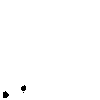

In [130]:
img.show()

In [57]:
# Importing required boundaries
from skimage.segmentation import slic, mark_boundaries
from skimage.data import astronaut
 
# Setting the plot figure as 15, 15
plt.figure(figsize=(15, 15))
 
# Sample Image of scikit-image package
# astronaut = astronaut()
astronaut = plt.imread('images 21.png')
 
# Applying SLIC segmentation
# for the edges to be drawn over
astronaut_segments = slic(astronaut,
                          n_segments=20) #, compactness=1)
 
plt.subplot(1, 2, 1)
 
# Plotting the original image
plt.imshow(astronaut)
 
# Detecting boundaries for labels
plt.subplot(1, 2, 2)
 
# Plotting the output of marked_boundaries
# function i.e. the image with segmented boundaries
plt.imshow(mark_boundaries(astronaut, astronaut_segments))

ModuleNotFoundError: No module named 'skimage'

In [62]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [65]:
astronaut_segments

array([[ 1,  1,  1, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  2,  2,  2],
       ...,
       [36, 36, 36, ..., 44, 44, 44],
       [36, 36, 36, ..., 44, 44, 44],
       [36, 36, 36, ..., 44, 44, 44]])

In [64]:
astronaut

array([[[1.        , 1.        , 1.        ],
        [0.98039216, 0.92156863, 0.84313726],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [0.98039216, 0.92156863, 0.84313726],
        [0.98039216, 0.92156863, 0.84313726]],

       [[0.98039216, 0.92156863, 0.84313726],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.49803922, 1.        , 0.83137256],
        [1.        , 1.        , 1.        ],
        [0.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.98039216, 0.92156863, 0.84313726],
        ...,
        [1.        , 1.        , 1.        ],
        [0.        , 1.        , 1.        ],
        [0.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.        , 1

In [63]:
image_show(color.label2rgb(astronaut_segments, astronaut, kind='avg'))

AttributeError: 'int' object has no attribute 'label2rgb'

In [70]:
import cv2
import numpy as np

In [95]:
# read the image
image = cv2.imread("images 21.png")

In [96]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

In [97]:
# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [102]:
# number of clusters (K)
k = 5
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [103]:
# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

In [104]:
# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

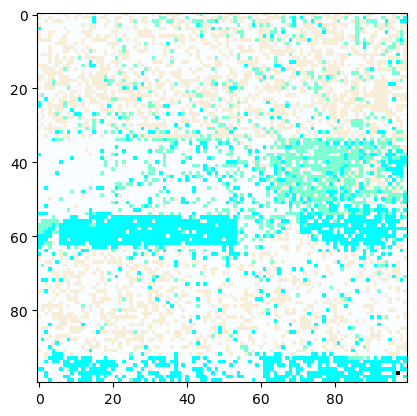

In [105]:
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

In [2]:
import cv2


In [ ]:
import cv2
 
# Read the original image
img = cv2.imread("images 21.png") 
# Display original image
cv2.imshow('Original', img)
# cv2.waitKey(0)
 
# Convert to graycsale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
 
# Sobel Edge Detection
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
# Display Sobel Edge Detection Images
cv2.imshow('Sobel X', sobelx)
cv2.waitKey(0)
cv2.imshow('Sobel Y', sobely)
cv2.waitKey(0)
cv2.imshow('Sobel X Y using Sobel() function', sobelxy)
cv2.waitKey(0)
 
# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
# Display Canny Edge Detection Image
cv2.imshow('Canny Edge Detection', edges)
# cv2.waitKey(0)
 
# cv2.destroyAllWindows()

In [4]:
import numpy as np

In [13]:
img = plt.imread("images 21.png").astype(float)


In [15]:
mask = img.astype(bool)


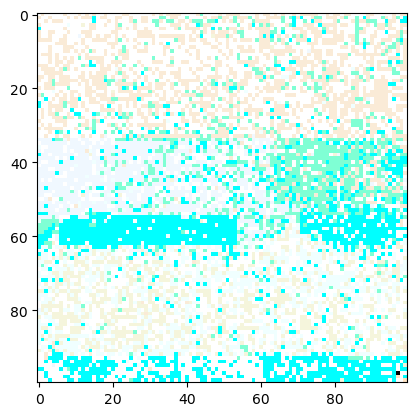

In [14]:
plt.imshow(img)

In [17]:
from sklearn.feature_extraction import image

graph = image.img_to_graph(img, mask=mask)

In [18]:
graph.data = np.exp(-graph.data / graph.data.std())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


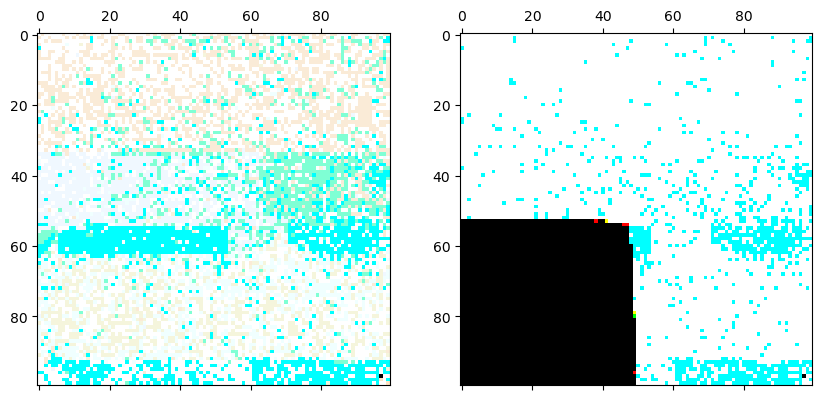

In [19]:
from sklearn.cluster import spectral_clustering
import matplotlib.pyplot as plt

labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

plt.show()

In [3]:
astronaut

array([[[154, 147, 151],
        [109, 103, 124],
        [ 63,  58, 102],
        ...,
        [127, 120, 115],
        [120, 117, 106],
        [125, 119, 110]],

       [[177, 171, 171],
        [144, 141, 143],
        [113, 114, 124],
        ...,
        [127, 118, 112],
        [124, 115, 108],
        [121, 116, 105]],

       [[201, 194, 193],
        [182, 178, 175],
        [168, 165, 164],
        ...,
        [128, 120, 117],
        [126, 116, 112],
        [124, 114, 109]],

       ...,

       [[186, 170, 176],
        [186, 170, 177],
        [183, 168, 170],
        ...,
        [  0,   0,   0],
        [  0,   0,   1],
        [  0,   0,   0]],

       [[183, 169, 170],
        [182, 167, 171],
        [185, 164, 176],
        ...,
        [  0,   0,   1],
        [  1,   1,   1],
        [  0,   0,   0]],

       [[184, 167, 172],
        [183, 165, 169],
        [180, 162, 171],
        ...,
        [  0,   0,   0],
        [  1,   1,   1],
        [  0,   0,   0]]

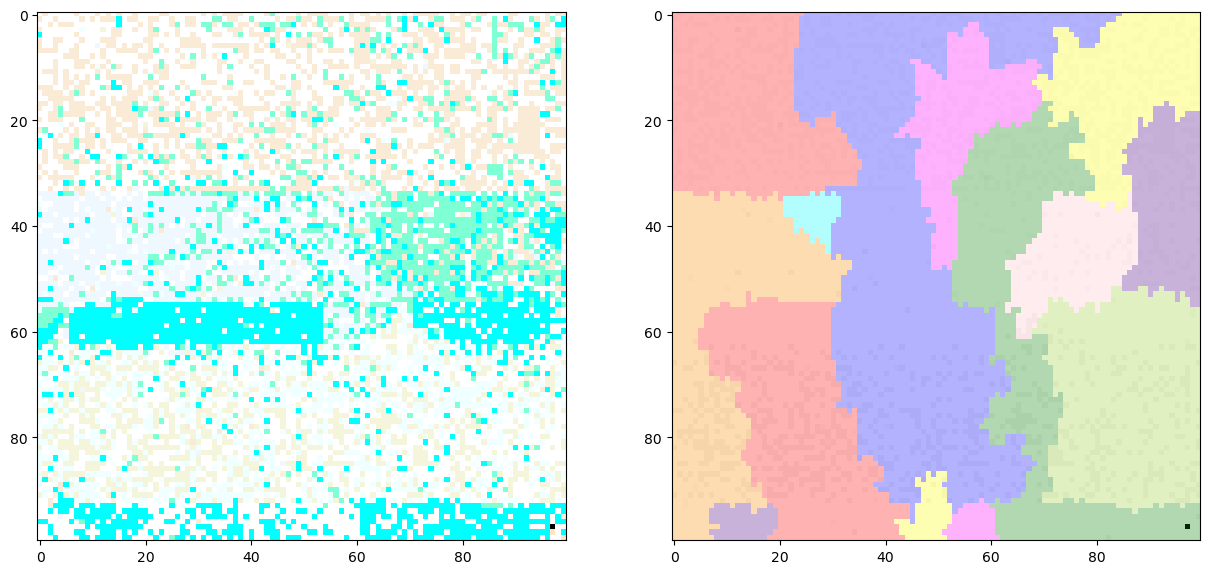

In [15]:
# Importing required libraries
from skimage.segmentation import slic
from skimage.data import astronaut
from skimage.color import label2rgb
import matplotlib.pyplot as plt 
# Setting the plot size as 15, 15
plt.figure(figsize=(15,15))
 
# Sample Image of scikit-image package
# astronaut = astronaut()
astronaut = plt.imread('images 21.png')
# Applying Simple Linear Iterative
# Clustering on the image
# - 50 segments & compactness = 10
astronaut_segments = slic(astronaut,
                          n_segments=100,
                          compactness=1)
plt.subplot(1,2,1)
 
# Plotting the original image
plt.imshow(astronaut)
plt.subplot(1,2,2)
 
# Converts a label image into
# an RGB color image for visualizing
# the labeled regions.
plt.imshow(label2rgb(astronaut_segments,
                     astronaut,
                     kind = 'overlay'))

In [16]:
colors

UsageError: %colors: you must specify a color scheme. See '%colors?'


In [24]:
import cv2
from PIL import ImageColor
import numpy as np

In [58]:
im = cv2.imread('images 21.png') # read input image

def getClosestColor(pixel,color_set_rgb): # Get the closest color for the pixel
    closest_color = None
    cost_init = 10000
    pixel = np.array(pixel)
    for color in color_set_rgb:
        color = np.array(color)
        cost = np.sum((color - pixel)**2)
        if cost < cost_init:
            cost_init = cost
            closest_color = color
    return closest_color

def getClosestImage(im): # Get the closest image
    color_set = [
 '#faebd7',
 '#f5f5dc',
 '#f0ffff',
 '#7fffd4',
 '#00ffff',
 '#ffe4c4',
 '#f0f8ff'] # Given Colorset
    color_set_rgb= [ImageColor.getrgb(color) for color in color_set] # RGB Colorset

    height, width, channels = im.shape
    im_out = np.zeros((height,width,channels))

    for y in range(0, height):
        for x in range(0, width):
            closest_color = getClosestColor(im[y, x],color_set_rgb)
            im_out[y,x,:] = closest_color
    return im_out

In [59]:
from PIL import Image
img = Image.open('images 21.png')
colr = img.getcolors()


In [60]:
colr

[(3468, (255, 255, 255)),
 (1485, (250, 235, 215)),
 (833, (245, 245, 220)),
 (997, (240, 255, 255)),
 (933, (127, 255, 212)),
 (1442, (0, 255, 255)),
 (2, (255, 228, 196)),
 (839, (240, 248, 255)),
 (1, (0, 0, 0))]

In [61]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb
rgb_to_hex((255, 255, 195))

'ffffc3'

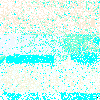

In [62]:
img

In [63]:
[f'#{rgb_to_hex(color[1])}' for color in colr]


['#ffffff',
 '#faebd7',
 '#f5f5dc',
 '#f0ffff',
 '#7fffd4',
 '#00ffff',
 '#ffe4c4',
 '#f0f8ff',
 '#000000']

In [38]:
from PIL import Image

def rgb2hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

img = Image.open('images 21.png')

if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):   
    pixels = list(img.convert('RGBA').getdata())

    for r, g, b, a in pixels: # just ignore the alpha channel
        print(rgb2hex(r, g, b))

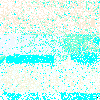

In [39]:
img

In [65]:
im.shape

(100, 100, 3)

In [69]:
np.array(img).shape

(100, 100, 3)

In [64]:
getClosestImage()

AttributeError: shape

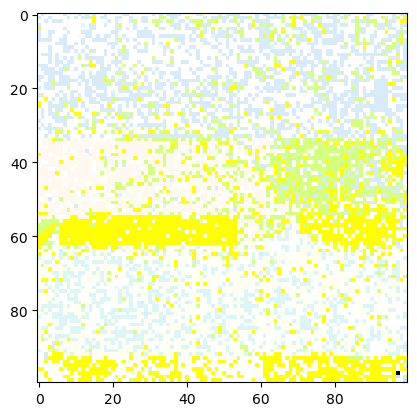

In [53]:
plt.imshow(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


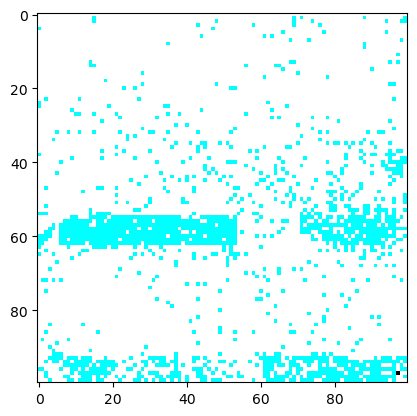

In [74]:
plt.imshow(getClosestImage(np.array(img).astype(np.uint8)))

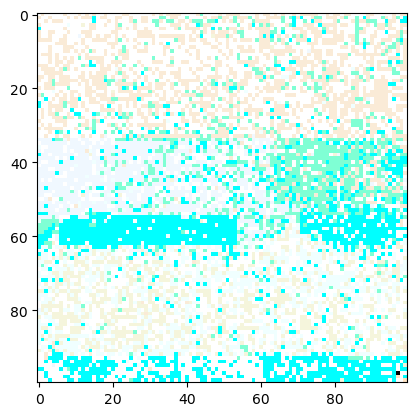

In [72]:
plt.imshow(img)

space_with_highest_range: 1
median_index: 5000
space_with_highest_range: 1
median_index: 2500
space_with_highest_range: 2
median_index: 1250
space_with_highest_range: 0
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 2
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 0
median_index: 1250
space_with_highest_range: 0
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 0
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 0
median_index: 2500
space_with_highest_range: 0
median_index: 1250
space_with_highest_range: 0
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 0
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 1
median_index: 1250
space_with_highest_range: 1
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 1
median_index: 625
to quantize:  625
to quantize:  625


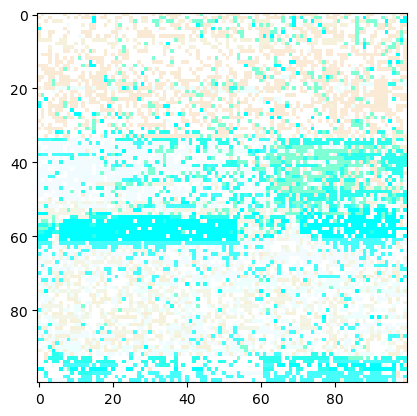

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
        
sample_img = imread('images 21.png')

def median_cut_quantize(img, img_arr):
    # when it reaches the end, color quantize
    print("to quantize: ", len(img_arr))
    r_average = np.mean(img_arr[:,0])
    g_average = np.mean(img_arr[:,1])
    b_average = np.mean(img_arr[:,2])
    
    for data in img_arr:
        sample_img[data[3]][data[4]] = [r_average, g_average, b_average]
    
def split_into_buckets(img, img_arr, depth):
    
    if len(img_arr) == 0:
        return 
        
    if depth == 0:
        median_cut_quantize(img, img_arr)
        return
    
    r_range = np.max(img_arr[:,0]) - np.min(img_arr[:,0])
    g_range = np.max(img_arr[:,1]) - np.min(img_arr[:,1])
    b_range = np.max(img_arr[:,2]) - np.min(img_arr[:,2])
    
    space_with_highest_range = 0

    if g_range >= r_range and g_range >= b_range:
        space_with_highest_range = 1
    elif b_range >= r_range and b_range >= g_range:
        space_with_highest_range = 2
    elif r_range >= b_range and r_range >= g_range:
        space_with_highest_range = 0

    print("space_with_highest_range:",space_with_highest_range)

    # sort the image pixels by color space with highest range 
    # and find the median and divide the array.
    img_arr = img_arr[img_arr[:,space_with_highest_range].argsort()]
    median_index = int((len(img_arr)+1)/2)
    print("median_index:", median_index)

    
    #split the array into two buckets along the median
    split_into_buckets(img, img_arr[0:median_index], depth-1)
    split_into_buckets(img, img_arr[median_index:], depth-1)
    
flattened_img_array = []
for rindex, rows in enumerate(sample_img):
    for cindex, color in enumerate(rows):
        flattened_img_array.append([color[0],color[1],color[2],rindex, cindex]) 
        
flattened_img_array = np.array(flattened_img_array)

# the 3rd parameter represents how many colors are needed in the power of 2. If the parameter 
# passed is 4 its means 2^4 = 16 colors
split_into_buckets(sample_img, flattened_img_array, 4)
plt.imshow(sample_img)


In [77]:
img = cv2.imread('images 21.png')

In [85]:
(img = [0,0,0])

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2070811373.py, line 1)

In [2]:
mask = (img == [255,255,255]).all(axis = 2, keepdims = True).astype(np.uint8)

In [3]:
mask = mask.reshape(100,100)

In [1]:
cv2.imshow(mask)

NameError: name 'cv2' is not defined

In [ ]:
import numpy as np
import cv2

img = cv2.imread('images 21.png')
mask = (img == [255,255,255]).all(axis = 2, keepdims = True).astype(np.uint8).reshape(100,100)
# mask = cv2.imread('mask2.png',0)

dst = cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)

cv2.imshow('dst',dst)